In [1]:
import tensorflow as tf
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'sstt'

In [2]:
samples, feature_names = load_input_file('data/sstt_w.h5')
input_features, targets, weights = build_combined_input(samples)

Found 9 features on the dataset 9 features were loaded: 

nJets_OR
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
jet_pseudoscore_DL1r2
Mll01
sumPsbtag
HT_jets
met_met
HT_lep
 
Dataset contains 270849 Signal events and 983568 Background events.


In [3]:
ScaleWeights(targets,weights)
#scale the input between 0-1
scaler = StandardScaler().fit(input_features)
input_scaled = scaler.transform(input_features)


======Weight Statistic========================================
Weights::        W(1)=1229.8, W(0)=1850.77
Scaled weights:: W(1)=627209, W(0)=627208


In [4]:
train, val, test = Train_Val_Test_Split(input_scaled, targets, weights)
n_epochs = 100
batch_size = 2000

In [5]:
# Function for Kfold Crossvalidation Training, it returns a list of the history and a list of the the models
#num_folds = 2
#history_list, model_list = Train_NN_Kfold(train, val, n_epochs, batch_size, num_folds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 36)                360       
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------------------
Training for fold 1 ...
Train on 514311 samples, val

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


514311/514311 [==============================] - 1s 2us/sample - loss: 0.3403 - accuracy: 0.8724 - val_loss: 0.2541 - val_accuracy: 0.8986
INFO LR Schedule: 0.01
Epoch 2/100
514311/514311 [==============================] - 1s 2us/sample - loss: 0.3010 - accuracy: 0.8934 - val_loss: 0.2624 - val_accuracy: 0.8954
INFO LR Schedule: 0.009
Epoch 3/100
514311/514311 [==============================] - 1s 2us/sample - loss: 0.2944 - accuracy: 0.8959 - val_loss: 0.2404 - val_accuracy: 0.9037
INFO LR Schedule: 0.009
Epoch 4/100
514311/514311 [==============================] - 1s 1us/sample - loss: 0.2911 - accuracy: 0.8963 - val_loss: 0.2430 - val_accuracy: 0.9029
INFO LR Schedule: 0.009
Epoch 5/100
514311/514311 [==============================] - 1s 2us/sample - loss: 0.2889 - accuracy: 0.8971 - val_loss: 0.2278 - val_accuracy: 0.9087
INFO LR Schedule: 0.0081
Epoch 6/100
514311/514311 [==============================] - 1s 2us/sample - loss: 0.2876 - accuracy: 0.8979 - val_loss: 0.2442 - val_acc

Train on 514311 samples, validate on 514311 samples
INFO LR Schedule: 0.01
Epoch 1/100
514311/514311 [==============================] - 1s 2us/sample - loss: 0.3395 - accuracy: 0.8757 - val_loss: 0.2554 - val_accuracy: 0.8979
INFO LR Schedule: 0.01
Epoch 2/100
514311/514311 [==============================] - 1s 2us/sample - loss: 0.3016 - accuracy: 0.8936 - val_loss: 0.2570 - val_accuracy: 0.8972
INFO LR Schedule: 0.009
Epoch 3/100
514311/514311 [==============================] - 1s 1us/sample - loss: 0.2946 - accuracy: 0.8967 - val_loss: 0.2524 - val_accuracy: 0.8995
INFO LR Schedule: 0.009
Epoch 4/100
514311/514311 [==============================] - 1s 2us/sample - loss: 0.2910 - accuracy: 0.8972 - val_loss: 0.2436 - val_accuracy: 0.9020
INFO LR Schedule: 0.009
Epoch 5/100
514311/514311 [==============================] - 1s 1us/sample - loss: 0.2888 - accuracy: 0.8981 - val_loss: 0.2442 - val_accuracy: 0.9010
INFO LR Schedule: 0.0081
Epoch 6/100
514311/514311 [=======================

In [6]:
input_shape = train[0].shape[1]
model = Create_Model_basic(input_shape)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 36)                360       
_________________________________________________________________
dropout_2 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_________________________________________________________________


In [7]:
#fit_history = Train_NN(model, train, val, n_epochs, batch_size)
#Plot_Metrics(fit_history, path_tosave)
#Save_Model(model, "sstt_1", path_tosave)

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/CatNN/NN_for_sstt/sstt/architecture_sstt_1.json, /mnt/c/Users/aaron/Desktop/CatNN/NN_for_sstt/sstt/weights_sstt_1.h5)


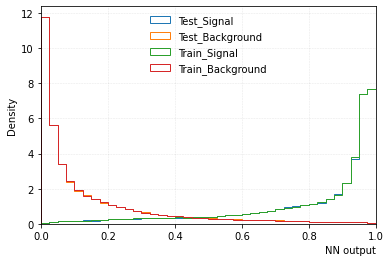

In [8]:
model=Load_Model("sstt_1", path_tosave)
Plot_NN_Output(model, train, test, False)

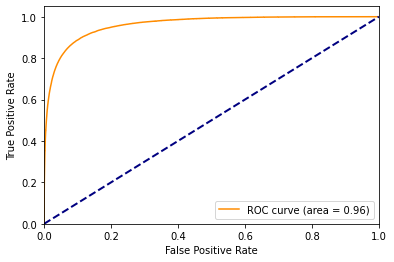

In [9]:
plot_roc_curve(model, test, path_tosave=path_tosave)